In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris, load_breast_cancer, fetch_california_housing,fetch_openml, make_classification
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectKBest, chi2, RFECV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import time

In [ ]:
#!pip install mrmr_selection

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.1/31.1 MB 14.6 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import mrmr

# 🧠 Selección de características (Feature Selection)

## ¿Qué es?

En ciencia de datos, muchas veces tenemos **muchas columnas (o "features")** en una tabla de datos. Pero **no todas las columnas son igual de útiles** para hacer predicciones o entender el problema.

La **selección de características** (en inglés *feature selection*) es el proceso de **elegir solo las columnas más importantes** para nuestro análisis o modelo de machine learning.

---

## 🎯 ¿Por qué es importante?

- Mejora la **precisión** del modelo.
- Reduce el **tiempo de entrenamiento** y la complejidad.
- Evita que el modelo aprenda "ruido" o datos irrelevantes.
- Hace que los resultados sean más fáciles de interpretar.

---

## 🧑‍🍳 Ejemplo del mundo real

Imagina que eres chef y quieres predecir si a alguien le va a gustar una receta. Tienes datos como:

- Edad del comensal  
- Si le gusta el picante  
- Tamaño del plato  
- Marca del horno usado  
- Número de letras en el nombre del plato  
- Ingredientes principales

Claramente, algunas columnas no tienen mucha relación con el gusto (por ejemplo, la **marca del horno** o el **número de letras**). Entonces, al hacer *feature selection*, te quedas solo con las **columnas relevantes**, como si le gusta el picante o los ingredientes.

---

## ✅ ¿Cómo se puede hacer?

Existen varias formas de hacer feature selection. Algunas comunes son:

- Usar **correlaciones** para ver qué columnas se relacionan con la variable que queremos predecir.
- Usar modelos como árboles de decisión para ver qué columnas considera importantes.
- Eliminar columnas con **muchos valores faltantes** o que tienen el **mismo valor en casi todos los registros**.

En el siguiente bloque de código, veremos un ejemplo práctico. 👇


🎯 Importancia de cada feature:
             feature  importancia
2  petal length (cm)     0.437380
3   petal width (cm)     0.391590
0  sepal length (cm)     0.138476
1   sepal width (cm)     0.032554


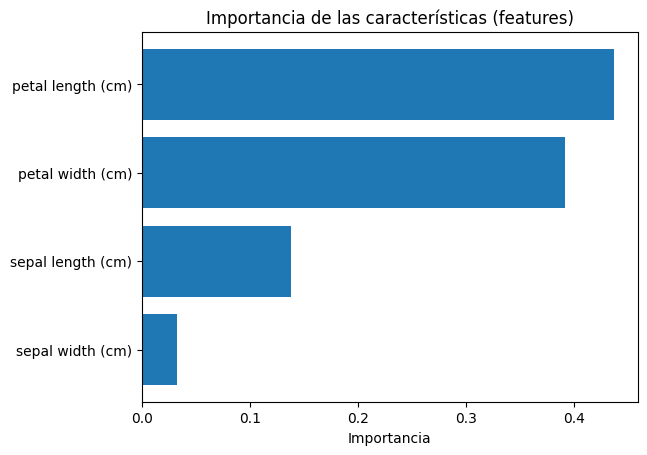

In [ ]:
# Cargar un conjunto de datos clásico (flores iris)
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df["target"] = iris.target

# Crear modelo
model = RandomForestClassifier()
model.fit(df[iris.feature_names], df["target"])

# Mostrar la importancia de cada columna
importancias = model.feature_importances_

# Crear tabla con resultados
importancia_df = pd.DataFrame({
    'feature': iris.feature_names,
    'importancia': importancias
}).sort_values(by='importancia', ascending=False)

print("🎯 Importancia de cada feature:")
print(importancia_df)

# Graficar
plt.barh(importancia_df['feature'], importancia_df['importancia'])
plt.xlabel("Importancia")
plt.title("Importancia de las características (features)")
plt.gca().invert_yaxis()
plt.show()

# 🧠 Métodos de Feature Selection: Con y Sin Interacción entre Features

## 👈 1. Métodos que **NO tienen en cuenta la interacción** entre las columnas (features)

Estos métodos analizan **cada columna por separado**, sin considerar cómo se combinan o influyen entre sí. Son simples y rápidos.

### 🔧 Técnicas comunes:

- **Filtro por correlación**: Elimina columnas que tienen poca o ninguna relación con la variable objetivo.
- **Chi-cuadrado (Chi²)**: Evalúa si una columna categórica y la variable objetivo están relacionadas.
- **Varianza baja**: Elimina columnas que casi no cambian (por ejemplo, una columna que siempre tiene el mismo valor).
- **Selección univariante (SelectKBest)**: Prueba cada columna individualmente con una prueba estadística.

📌 Útiles cuando:
- Se quiere una primera limpieza de columnas irrelevantes.
- No hay mucho poder computacional.

## 🎯 SelectKBest: Selección univariante de columnas

`SelectKBest` es una técnica que **evalúa cada columna (feature) de forma individual** y selecciona las mejores según una medida estadística.

👉 Esto es útil como primer filtro para eliminar columnas irrelevantes, sin necesidad de entrenar un modelo.

---

### 🧪 Parámetro `score_func`: ¿Cómo decide qué columnas son "las mejores"?

El parámetro `score_func` define **la prueba estadística** que se usará para puntuar cada columna. Aquí están las opciones más comunes y cuándo usarlas:

---

#### 1. `chi2`: Prueba chi-cuadrado

- 📊 Tipo de datos: **Features categóricas o numéricas positivas (escaladas)** y **objetivo categórico**.
- 🧠 ¿Qué mide?: Qué tan dependiente es una columna respecto a la variable objetivo.
- 🧪 Ejemplo: Evaluar si el número de compras está relacionado con el género (masculino/femenino).
- ⚠️ Requiere que los valores sean **mayores o iguales a 0** (usar `MinMaxScaler` si son numéricos).

---

#### 2. `f_classif`: Prueba ANOVA F (para clasificación)

- 📊 Tipo de datos: **Features numéricas** y **objetivo categórico**.
- 🧠 ¿Qué mide?: Si las medias de una feature cambian significativamente entre diferentes clases.
- 🧪 Ejemplo: Evaluar si la altura promedio cambia entre pacientes con o sin enfermedad.
- ✅ Muy usado cuando la tarea es **clasificación**.

---

#### 3. `f_regression`: Prueba F para regresión

- 📊 Tipo de datos: **Features numéricas** y **objetivo numérico continuo**.
- 🧠 ¿Qué mide?: Cuánto contribuye una feature a predecir una variable numérica.
- 🧪 Ejemplo: Ver qué columnas ayudan más a predecir el precio de una casa.
- ✅ Usado en tareas de **regresión** (predicción de valores continuos).

---

### 🧠 Recomendación general

| score_func    | Tarea del modelo | Tipo de variable objetivo | Tipo de features   |
|---------------|------------------|----------------------------|--------------------|
| `chi2`        | Clasificación    | Categórica                 | Categóricas o numéricas positivas |
| `f_classif`   | Clasificación    | Categórica                 | Numéricas          |
| `f_regression`| Regresión        | Numérica continua          | Numéricas          |

Usa este método como **primer paso** antes de entrenar un modelo más complejo 🚀


In [ ]:
# Cargar dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Escalar los datos para que chi2 funcione correctamente
X_scaled = MinMaxScaler().fit_transform(X)

# Aplicar SelectKBest con prueba chi-cuadrado
selector = SelectKBest(score_func=chi2, k=5)
X_new = selector.fit_transform(X_scaled, y)

# Mostrar las columnas seleccionadas
selected_features = X.columns[selector.get_support()]
print("✅ Features seleccionadas (sin interacción):")
print(selected_features.tolist())


✅ Features seleccionadas (sin interacción):
['mean concavity', 'mean concave points', 'worst perimeter', 'worst area', 'worst concave points']


-----------

## 🤝 2. Métodos que **SÍ tienen en cuenta la interacción** entre columnas

Estos métodos consideran **cómo se combinan varias columnas** para hacer mejores predicciones. Son más avanzados y cercanos al funcionamiento real de los modelos.

#### 🔧 Técnicas comunes:

- **Lasso (con regularización L1)**: Penaliza columnas menos importantes, dejando solo las esenciales.
- **MRMR**:Minima redundancia / Maxima relevancia.
- **Modelos de árboles (Random Forest, XGBoost)**: Analizan combinaciones de columnas para predecir la variable objetivo.
- **RFECV (Recursive Feature Elimination)**: Quita columnas una por una, evaluando el desempeño del modelo cada vez con cross validation.

📌 Útiles cuando:
- Queremos construir un modelo con alto rendimiento.
- Queremos entender **cómo trabajan juntas** las variables para influir en la predicción.

---

En los siguientes bloques de código veremos un ejemplo de cada tipo. 👇

## 🧮 LASSO: Selección de características con regresión

### 🧠 ¿Qué es LASSO?

LASSO (Least Absolute Shrinkage and Selection Operator) es una técnica de regresión que **no solo hace predicciones**, sino que también **selecciona automáticamente las columnas más importantes** para el modelo.

---

### 🧰 ¿Cómo funciona?

LASSO funciona como un modelo de regresión tradicional (como predecir el precio de una casa), pero con una diferencia clave:

👉 Le **"penaliza"** a las columnas que no ayudan mucho a la predicción.  
👉 Si una columna no aporta información útil, LASSO le pone un **peso de cero**, es decir, la **descarta automáticamente**.

Es como si estuvieras en un grupo de trabajo: si alguien no está aportando al proyecto, LASSO le dice "¡gracias, pero no más!" 😄

---

### 📉 ¿Por qué es útil?

- Elimina automáticamente las columnas irrelevantes.
- Ayuda a evitar el sobreajuste (cuando el modelo aprende ruido en lugar de patrones reales).
- Hace que los modelos sean más simples y fáciles de interpretar.

---

### 📌 ¿Cuándo usar LASSO?

- Cuando tienes **muchas columnas** y no sabes cuáles son realmente importantes.
- Cuando necesitas **entender mejor** qué variables afectan la predicción.
- Cuando quieres un modelo más **simple y rápido**.

---

### 🎯 Ejemplo del mundo real

Imagina que estás tratando de predecir el precio de un apartamento. Tienes columnas como:

- Número de habitaciones  
- Piso  
- Tamaño en m²  
- Número de plantas en el edificio  
- Día de la semana en que se publicó el aviso  
- Color de las paredes  

Claramente, algunas columnas no ayudan (como el color de las paredes). LASSO se encarga de **detectar y eliminar** esas automáticamente al entrenar el modelo.

In [ ]:
# Cargar el dataset California Housing
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Escalar los datos (LASSO lo necesita para que todas las columnas estén en la misma escala)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Entrenar un modelo LASSO con penalización alpha
lasso = Lasso(alpha=0.1)
lasso.fit(X_scaled, y)

# Ver qué columnas fueron seleccionadas (coeficientes distintos de cero)
selected_features = X.columns[lasso.coef_ != 0]
discarded_features = X.columns[lasso.coef_ == 0]

print("✅ Features seleccionadas por LASSO:")
print(selected_features.tolist())

print("\n🚫 Features descartadas por LASSO:")
print(discarded_features.tolist())

✅ Features seleccionadas por LASSO:
['MedInc', 'HouseAge', 'Latitude']

🚫 Features descartadas por LASSO:
['AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Longitude']


-------------------

## 🧠 MRMR: Minimum Redundancy Maximum Relevance

MRMR es un método de selección de características que busca un **equilibrio inteligente** entre:

✅ Elegir las columnas **más relevantes** para la variable que queremos predecir  
🚫 Evitar columnas que **repiten la misma información** (redundantes)

---

### 🎯 ¿Cómo funciona?

Imagina que estás eligiendo un grupo de personas para resolver un problema:

- Quieres a los que **más saben del tema** (relevancia máxima con el objetivo).
- Pero también quieres que **no digan lo mismo una y otra vez** (redundancia mínima entre ellos).

Eso es exactamente lo que hace MRMR:
- Evalúa **cuánto aporta cada columna** a la predicción.
- Pero también mide **cuánto se parece esa columna a las ya seleccionadas** (para no repetir información).

---

### 🧪 ¿Cuándo usar MRMR?

- Cuando tienes **muchas columnas** y no sabes cuáles usar.
- Cuando quieres evitar **columnas duplicadas o que digan lo mismo con otras palabras**.
- Cuando estás haciendo **clasificación o regresión** y necesitas un subconjunto más limpio y explicativo.

---

### 🌎 Ejemplo de la vida real

Supongamos que estás prediciendo si un paciente tiene diabetes. Tienes columnas como:

- Nivel de azúcar en sangre  
- Porcentaje de hemoglobina glucosilada (que también mide azúcar)  
- Edad  
- Peso  
- Presión arterial  

MRMR detectaría que **azúcar en sangre y hemoglobina glucosilada son muy similares**, y te dejaría solo una. Así, el modelo **aprende más con menos columnas**.

In [ ]:
# Cargar un dataset de ejemplo desde openML (Heart Disease)
df = fetch_openml("heart-statlog", version=1, as_frame=True).frame
# Convertir la variable objetivo en números si es categórica
df["class"] = LabelEncoder().fit_transform(df["class"])

# Separar features y objetivo
X = df.drop(columns=["class"])
y = df["class"]

# MRMR necesita un solo DataFrame con todas las columnas, incluyendo el target
df_full = X.copy()
df_full["class"] = y

# Aplicar MRMR para seleccionar las 5 mejores columnas
selected = mrmr.mrmr_classif(
    X=df_full.drop(columns="class"),
    y=df_full["class"], K=5
)

print("✅ Features seleccionadas por MRMR:")
print(selected)

100%|██████████| 5/5 [00:00<00:00, 79.09it/s]

✅ Features seleccionadas por MRMR:
['thal', 'resting_electrocardiographic_results', 'number_of_major_vessels', 'chest', 'oldpeak']


-------


## 🔍 RFECV: Eliminación recursiva de características con validación cruzada

`RFECV` es una técnica automática de selección de columnas que:

✅ Utiliza un modelo (como `LogisticRegression` o `RandomForest`)  
🔁 Elimina columnas una por una, de forma inteligente  
📈 Evalúa el rendimiento del modelo en cada paso con validación cruzada  
🎯 Se queda con el subconjunto de columnas que **mejor desempeño da al modelo**

---

### 🧠 ¿Cómo funciona?

1. Entrena un modelo con **todas las columnas**.
2. Elimina la columna **menos importante** (según el modelo).
3. Repite el proceso hasta quedarse solo con las más útiles.
4. Usa **validación cruzada** en cada paso para medir qué tan bueno es el modelo.
5. Devuelve el subconjunto óptimo de columnas.

Es como probar diferentes equipos de trabajo y elegir aquel que **trabaja mejor con menos personas**.

---

### 🧪 ¿Cuándo usar RFECV?

- Cuando tienes un modelo en mente y quieres que **elija las mejores columnas**.
- Cuando quieres **automáticamente balancear simplicidad y rendimiento**.
- Cuando te importa que las variables seleccionadas **interactúen bien entre sí**.

---

### 🌎 Ejemplo de la vida real

Supón que estás entrenando un modelo para predecir si un correo es spam. Tienes columnas como:

- Número de signos de exclamación  
- Cantidad de palabras en mayúsculas  
- Presencia de palabras como "gratis", "urgente", etc.  
- Longitud del asunto  
- Cantidad de errores ortográficos  

RFECV puede evaluar distintas combinaciones de estas columnas y elegir solo las que realmente ayudan al modelo a identificar correctamente los correos spam, descartando las que confunden o no aportan.


In [ ]:
# Cargar dataset de cáncer de mama
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Escalar los datos (importante para modelos lineales)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Modelo base: regresión logística
model = LogisticRegression(max_iter=1000)

# Aplicar RFECV con validación cruzada estratificada
rfecv = RFECV(
    estimator=model,
    step=1,
    cv=StratifiedKFold(5),
    scoring='accuracy',
    min_features_to_select = 10)
rfecv.fit(X_scaled, y)

# Mostrar resultados
print(f"✅ Número óptimo de features: {rfecv.n_features_}")
print("🔍 Features seleccionadas:")
print(X.columns[rfecv.support_].tolist())


✅ Número óptimo de features: 30
🔍 Features seleccionadas:
['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']


# 🧪 Ejercicio práctico: ¿Vale la pena seleccionar variables?

En este ejercicio pondrás en práctica lo aprendido sobre **feature selection** y evaluarás su impacto en el entrenamiento de un modelo de machine learning.

---

## 🎯 Objetivo

Comparar dos modelos de clasificación que predicen si un tumor es maligno o benigno:

1. Un modelo entrenado con **todas las columnas** disponibles en el dataset.
2. Un modelo entrenado **solo con las columnas seleccionadas automáticamente** mediante el método `RFECV`.

---

## 🧰 Lo que debes hacer

A partir del dataset de cáncer de mama (`sklearn.datasets.load_breast_cancer`), realiza lo siguiente:

### Paso 1: Cargar y dividir los datos
- Separa el dataset en entrenamiento y prueba.

### Paso 2: Modelo base (sin selección de variables)
- Construye un pipeline que incluya:
  - Imputación (`SimpleImputer`)
  - Escalado (`StandardScaler`)
  - Modelo (`LogisticRegression`)
  - Optimización de hiperparámetros con `GridSearchCV`
- Entrena el modelo con **todas las columnas** y evalúalo.

### Paso 3: Feature selection con RFECV
- Usa `RFECV` para seleccionar las columnas más útiles basándote **solo en el conjunto de entrenamiento**.

### Paso 4: Modelo con variables seleccionadas
- Repite el mismo pipeline anterior pero **usando solo las columnas seleccionadas** por RFECV.

### Paso 5: Comparación
- Compara ambos modelos en términos de:
  - Tiempo de entrenamiento
  - Accuracy
  - F1-Score
  - Número de columnas usadas
- Reflexiona sobre: ¿vale la pena usar menos columnas? ¿se pierde desempeño?

---

## 💡 Sugerencias

- Usa `time.time()` para medir los tiempos.
- Asegúrate de aplicar la misma estrategia de imputación y escalado en ambos modelos.
- Usa `StratifiedKFold` para mantener el equilibrio de clases durante la validación cruzada.

---

## 🚀 Nivel extra (opcional)
- Repite el ejercicio con un modelo distinto (por ejemplo `RandomForestClassifier`) y compara los resultados.
- Visualiza con una gráfica cómo cambia el rendimiento durante la selección recursiva con RFECV.

---

Cuando termines, discute tus hallazgos con tus compañeros o escribe una breve conclusión explicando qué aprendiste sobre la selección de variables.


In [29]:
# 1. Cargar el dataset
# Crear un dataset sintético
X, y = make_classification(
    n_samples=10000,
    n_features=30,
    n_informative=10,
    n_redundant=10,
    n_repeated=0,
    n_clusters_per_class=2,
    random_state=42,
    shuffle=False
)

# Crear DataFrame
feature_names = [f"feature_{i}" for i in range(X.shape[1])]
X = pd.DataFrame(X, columns=feature_names)

In [30]:
# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# 3. Pipeline base (sin feature selection)
# Preprocesador
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [32]:
# Hiperparámetros a explorar
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [4, 6, 8]
}

In [33]:
# Modelo
model = RandomForestClassifier(random_state=42)

skf = StratifiedKFold(5,shuffle=True,random_state=0)
# Modelo con TODAS las variables
pipe_all = Pipeline([
    ('prep', preprocessor),
    ('clf', GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=skf
    ))
])

start_all = time.time()
pipe_all.fit(X_train, y_train)
end_all = time.time()

# Métricas con todas las features
y_pred_all = pipe_all.predict(X_test)
print("🔵 Modelo con todas las variables")
print("Accuracy:", accuracy_score(y_test, y_pred_all))
print("F1 Score:", f1_score(y_test, y_pred_all))
print("Tiempo de entrenamiento:", end_all - start_all, "segundos")

🔵 Modelo con todas las variables
Accuracy: 0.922
F1 Score: 0.9196704428424305
Tiempo de entrenamiento: 25.63673996925354 segundos


In [ ]:
# 5. Selección de features con RFECV (solo en entrenamiento)

# Aplicar preprocesamiento antes de RFECV
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

# Selección de features
selector = RFECV(
    estimator=RandomForestClassifier(random_state=42),
    step=1,
    cv=StratifiedKFold(5),
    scoring='f1',
    n_jobs=-1
)

X_train_sel = selector.fit_transform(X_train_prep, y_train)
X_test_sel = selector.transform(X_test_prep)
selected_features = np.array(feature_names)[selector.support_]

In [ ]:
#6. Modelo con features seleccionadas
grid_sel = GridSearchCV(
    estimator=model,
    param_grid={'n_estimators': [50, 100], 'max_depth': [4, 6, 8]},
    cv=5
)

start_sel = time.time()
grid_sel.fit(X_train_sel, y_train)
end_sel = time.time()

# Métricas con features seleccionadas
y_pred_sel = grid_sel.predict(X_test_sel)
print("\n🟢 Modelo con features seleccionadas")
print("Features seleccionadas:", list(selected_features))
print("Accuracy:", accuracy_score(y_test, y_pred_sel))
print("F1 Score:", f1_score(y_test, y_pred_sel))
print("Tiempo de entrenamiento:", end_sel - start_sel, "segundos")


🟢 Modelo con features seleccionadas
Features seleccionadas: [np.str_('feature_0'), np.str_('feature_1'), np.str_('feature_2'), np.str_('feature_3'), np.str_('feature_4'), np.str_('feature_5'), np.str_('feature_6'), np.str_('feature_7'), np.str_('feature_8'), np.str_('feature_9'), np.str_('feature_10'), np.str_('feature_11'), np.str_('feature_12'), np.str_('feature_13'), np.str_('feature_14'), np.str_('feature_15'), np.str_('feature_16'), np.str_('feature_17'), np.str_('feature_18'), np.str_('feature_19')]
Accuracy: 0.9245
F1 Score: 0.9223650385604113
Tiempo de entrenamiento: 36.928837299346924 segundos


# Modelo

In [21]:
# 1. Cargar el dataset
# Crear un dataset sintético
X, y = make_classification(
    n_samples=10000,
    n_features=30,
    n_informative=10,
    n_redundant=10,
    n_repeated=0,
    n_clusters_per_class=2,
    random_state=42,
    shuffle=False
)

# Crear DataFrame
feature_names = [f"feature_{i}" for i in range(X.shape[1])]
X = pd.DataFrame(X, columns=feature_names)

In [22]:
# Divido los datos en conjunto de entrenamiento (75%) y prueba (25%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)  

In [23]:
np.unique(y, return_counts=True)

(array([0, 1]), array([5004, 4996]))

In [28]:
# Creamos un Pipeline con StandardScaler y Regresion Lineal
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ('scaler', StandardScaler()),
    ('regressor', LogisticRegression())
])

param_grid = {}

grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor score:", grid_search.best_score_)

Mejores hiperparámetros: {}
Mejor score: 0.8162666666666667


In [ ]:
# Cargar dataset de cáncer de mama
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Escalar los datos (importante para modelos lineales)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Modelo base: regresión logística
model = LogisticRegression(max_iter=1000)

# Aplicar RFECV con validación cruzada estratificada
rfecv = RFECV(
    estimator=model,
    step=1,
    cv=StratifiedKFold(5),
    scoring='accuracy',
    min_features_to_select = 10)
rfecv.fit(X_scaled, y)

# Mostrar resultados
print(f"✅ Número óptimo de features: {rfecv.n_features_}")
print("🔍 Features seleccionadas:")
print(X.columns[rfecv.support_].tolist())
